In [5]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
import time

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Web Component Performance Testing

> In the previous chapters I went with you through the geneneration of components on web sites.
> We took a look at the different possibilities of creating components on the web:
> 1. **The traditional component** with some markup that get's it's styling from some globally defined css classes  
> behaving according to some globally defined JavaScript
> 2. **The JavaScript class**, which directly binds the appearance to the markup
> 3. **The web componenet**, that encloses markup, stlying and behaviour
>
> Furthermore we took a look at three today very popular frameworks/ libraries, which facilitate the lives of web developers: 
> - We created web components with the help of **Angular, Vue and Polymer**

---
In this chapter we will try to find out how the different components perform.  

Afterwards we want to answer the following questions:
- Which of the components perform best?
- How much does the framework addition add to the components?  
And how severe is this effect when creating multiple components?  
Will the effect be eliminated then?
- which of the frameworks/ libraries create the best performing web components?
---


First we need to start the servers of all the applications in a different terminal windows
- Traditional component: `cd 03_Performance-Test/webcomponents/00_progress-bar/00_global-styling && python3 ./server.py`
- JavaScript component: `cd 03_Performance-Test/webcomponents/00_progress-bar/01_js-component && python3 ./server.py`
- Web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/02_web-component && python3 ./server.py`
- Angular web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/03-angular && python3 ./server.py`
- Polymer web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/04-polymer && python3 ./server.py`
- Vue web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/05-vue && python3 ./server.py`


For measuring how long the html page would take until it is rendered including the components we will use `performance.now()`.  
At the beginning of our HTML body we will start the timer `bodyRendering` and stop the timer in the first iteration round of our component complete attribute change. 

We do this here, and not just at the end of the body, to be sure, that the components were rendered already.  
Otherwise it could be that however our body completed rendering, the JavaScript responsible for rendering the components was not executed yet. Which would leave us with wrong test results.

Furthermore we will save our time measurement in the LocalStorage of the browser.  
We do this for not loosing the information of the time measurement after a new session aka a page reload.




```html
<!-- ... -->
<body>
    <script>let bodyRendering = performance.now()</script>

    <h1>Polymer - Stress Test (120)</h1>
    <progress-bar id="progress-bar-1" class="pa-1"></progress-bar>
    <!-- ... -->
    <!-- ... -->
    <!-- ... -->
    <script src="static/node_modules/@webcomponents/webcomponentsjs/webcomponents-loader.js"></script>
    <script type="module" src="static/progress-bar-polymer.js"></script>

    <script>
    // ...
    // inside our interval
        let progressInterval = setInterval(() => {
        
        // check whether you are in the first iteration round
            if(complete === 5) {
        
                // calculate the passed time of our body rendering 
                // and get the 'bodyRendering' token from LocalStorage
                let passedTime = parseFloat(performance.now()) - parseFloat(bodyRendering)
                let lsBR = JSON.parse(localStorage.getItem('bodyRendering'))
        
                // if the token in the LocalStorage exists, append the newly calculated time
                // otherwise create a new object with an array, 
                // that has the calculated time as it's initial item
                if(lsBR)
                    lsBR.push(passedTime)
                else
                    lsBR = [passedTime]

                localStorage.setItem('bodyRendering', JSON.stringify(lsBR))
            }
    // rest of our attribute modification
    // ...
    </script>
</body>

```


After reloaded the web site 5 times, the JSON _(JavaScript Object Notation)_ in the LocalStorage will look somethink like this:  
```json
[
    148.40000000003783,
    149.19999999983702,
    146.39999999963038,
    150.80000000034488,
    146.60000000003492
]

```
This test must be included in all the `index.html` files of our component.

Calling the different `URLs` in our browser already allows us to compare the performance of the different components.  
However there is a lot of stuff that may influence our performance measurements eg.:
- current network capacity utilization
- background tasks of our macbook

For getting decent test results we need to call all the applications multiple times and then compare the sum of our time measurements.  
Since we are programmers and love automation, **Selenium** will do the job for us.

Let's write a Python script and define the function `check_performance()`.  
This function will automatically open the different applications in a chrome web browser for a certain amount of times.  
_(I desided to go with 100 page calls)_

Furthermore let's save the result in the LocalStorage into a `JSON` file: `bodyRendering.json`.

In [6]:
chromedriver = "/usr/local/bin/chromedriver"


def check_performance(port=8000, sleep=2, page_calls=100,
					  foldername='00-global-styling', 
					  path='performance_test_result/00_progress-bar'):
	"""opens the chrome browser multiple times 
        and saves the token contents from 'bodyRendering' into a bodyRender.json file
	    
	Args:
		port: Number defining on which port of localhost the application is running on
		sleep: time in seconds before page reload
		page_calls: amount of times the URL is requested
		foldername: name of the folder, where to store the resulting JSON file
		path: relative path to foldername
	"""
    
    # first we open a chrome browser window with the help of Selinium's webdriver
    # we wait 30 mili seconds for the browser window to open
	url = 'http://127.0.0.1:' + str(port)
	driver = webdriver.Chrome(chromedriver)
	driver.implicitly_wait(100)
	
    # in a loop we reload the page n times
    # for making sure the page was rendered completely and the LocalStorage was filled 
        # we wait some seconds before the page refresh
	for i in range(page_calls):
		driver.get(url)
		time.sleep(sleep)
	
    # let's get the LocalStogage 'bodyRendering' token
	result = driver.execute_script("return localStorage.getItem('bodyRendering')")
	
    # close the browser session
	driver.quit()
	
	local_path = path
	
	#get current working directory
	path = os.getcwd() + '/' + path + '/' + foldername
	
    # write the resulting JSON file
	f = open(path + "/BodyRendering.json","w")
	f.write(result)
	f.close()
	print('🥳  🎉 🍾 Yay, successfully created "'+ local_path + '/' + foldername + '/BodyRendering.json"' )
	
	# return the mean value of our resulting performance array
	return pd.read_json(result).mean()[0]
		



Now, since we've defined our performance measurement function let's iterate over the folders, where the resulting `bodyRendering.json` should be written to.  

For providing most possible equal conditions, you should try to close all running applications and leave your computer do the measurements.  
**Important**: your computer shouldn't fall into sleep mode during this process.

If you do 100 page calls through 6 applications with a sleep time of two seconds, this will take about:
- $f(time\_check\_performance) = 100 \times 6 \times 2sec = 1200sec = 20min$


In [133]:
foldernames = ['00-global-styling', 
               '01-js-component', 
               '02-webcomponent', 
               '03-angular', 
               '04-polymer', 
               '05-vue']

[check_performance(page_calls=100, foldername=foldernames[i], port=8000+i) for i in range(len(foldernames))]

🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/00-global-styling/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/01-js-component/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/02-webcomponent/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/03-angular/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/04-polymer/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/05-vue/BodyRendering.json"


[108.41100000012375,
 119.36299999990297,
 126.55399999977817,
 168.9989999998943,
 107.88999999993393,
 153.8029999999344]

Next let's take a look at the json files.

In [10]:
body_rendering_path = 'performance_test_result/00_progress-bar/'

# read the json files in with pandas
global_styling_dataframe = pd.read_json(body_rendering_path + '00-global-styling/BodyRendering.json')
js_component_dataframe = pd.read_json(body_rendering_path + '01-js-component/BodyRendering.json')
web_component_dataframe = pd.read_json(body_rendering_path + '02-webcomponent/BodyRendering.json')
angular_dataframe = pd.read_json(body_rendering_path + '03-angular/BodyRendering.json')
polymer_dataframe = pd.read_json(body_rendering_path + '04-polymer/BodyRendering.json')
vue_dataframe = pd.read_json(body_rendering_path + '05-vue/BodyRendering.json')

# create a dataframe for the plain components and set the column names
frames = [global_styling_dataframe, 
          js_component_dataframe,
          web_component_dataframe]
performance_columns = ['global_styling', 'js_component', 'web_component']
performance_dataframe = pd.concat(frames, axis=1, sort=False)
performance_dataframe.columns = performance_columns

# create a dataframe out of the framework generated web components and define the column names
frames_frameworks = [angular_dataframe,
                     polymer_dataframe,
                     vue_dataframe]
performance_columns_frameworks = ['angular', 'polymer', 'vue']

# combine both dataframes
performance_dataframe_frameworks = pd.concat(frames + frames_frameworks, axis=1, sort=False)
performance_dataframe_frameworks.columns = performance_columns + performance_columns_frameworks


performance_dataframe_frameworks.describe()


,global_styling,js_component,web_component,angular,polymer,vue
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,108.4,119.4,126.6,169.0,107.9,153.8
std,7.9,7.4,7.1,14.2,7.3,10.3
min,104.0,113.3,118.5,158.2,103.3,144.0
25%,105.6,117.3,124.6,165.5,105.0,150.4
50%,107.1,118.5,125.7,167.5,107.3,152.1
75%,109.7,120.0,127.5,169.6,108.7,155.4
max,182.2,188.7,192.7,304.4,176.1,247.6


From the pandas dataframe description, one can already analyze the differences.

Let's have a look at the calculated mean values:
- polymer and global_styling have the lowest calculated mean value, which is close to 100ms
- global_styling/polymer to the js_component has the same distance in their mean value  
as the js_component to the web_component, which is about 10ms
- from the web_component to vue it's about twice the difference  
compared to the distance between the web_component and js_component,   
which is about 20ms
- from vue to angular its as well about 20ms

Which is very interesting here is the huge standard deviation.

Let's further analyze our dataframe by visualizing it with a line graph:



<Figure size 432x288 with 0 Axes>

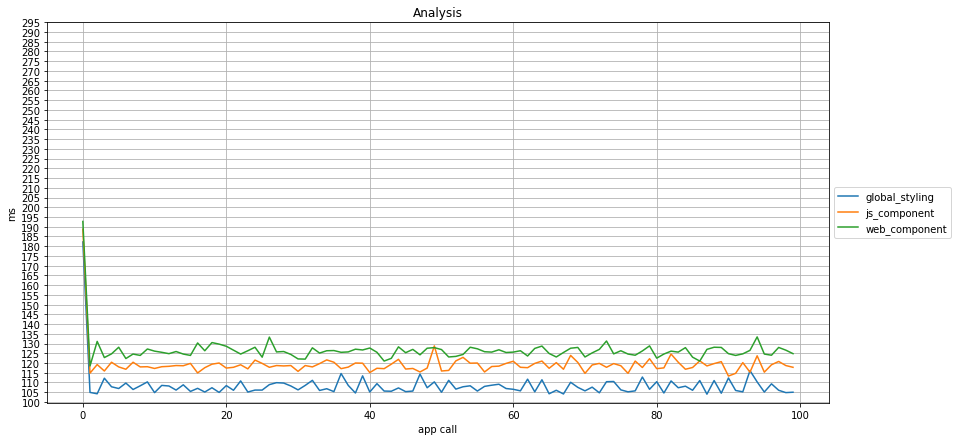

<Figure size 432x288 with 0 Axes>

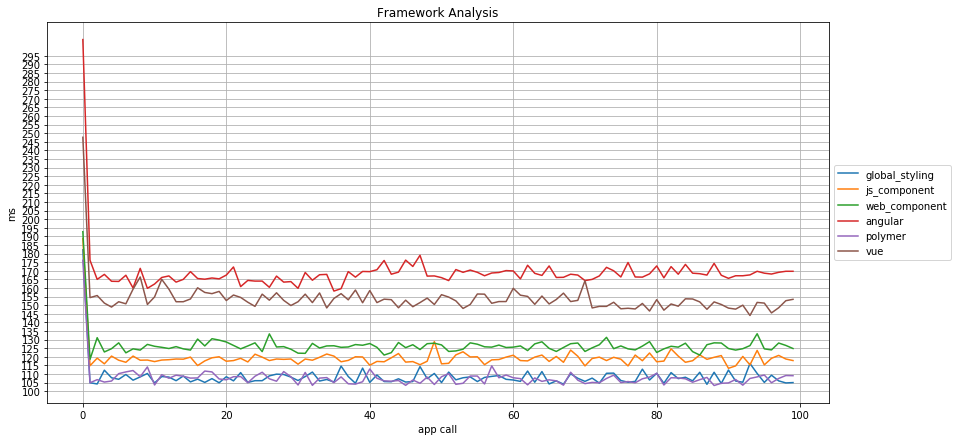

In [5]:
# figure for the plain components
f = plt.figure()
performance_dataframe.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, 
                           yticks=range(100,300,5),stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

# figure for the web components created with the frameworks
f = plt.figure()
performance_dataframe_frameworks.plot(kind='line',figsize=(14,7), title="Framework Analysis",
                                      yticks=range(100,300,5), grid=True,stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

After visualizing, we already see where the huge standard deviation comes from:  
- it's the first call after we opened the chrome browser with *Selenium*.

The interesting question now is, weather we would get different results, if we open and close the browser for each performance test.

Let's try this out by redefining our performance function:

In [47]:
chromedriver = "/usr/local/bin/chromedriver"


def check_performance_new_boot(port=8000, sleep=2, page_calls=100,
							   foldername='00-global-styling', 
							   path='performance_test_result/00_progress-bar'):
	"""opens chrome browser multiple times 
        and saves the token contents from 'bodyRendering' into a bodyRender.json file
	    
	Args:
		port: Number defining on which port of localhost the application is running on
		sleep: time in seconds before page reload
		page_calls: amount of times the URL is requested
		foldername: name of the folder, where to store the resulting JSON file
		path: relative path to foldername
	"""
    
	# first we define the url of the application 
	# and initialize our resulting performance array
	url = 'http://127.0.0.1:' + str(port)
	result = []
	
	# in a loop we open and close the chrome browser and get the specified url
	# for making sure the page was rendered completely and the LocalStorage was filled 
		# we wait some seconds before we add the single value in the LocalStorage array 
		# to our resulting performance array
	for i in range(page_calls):
		driver = webdriver.Chrome(chromedriver)
		driver.implicitly_wait(100)
		driver.get(url)
		time.sleep(sleep)
		result.append(pd.read_json((
            driver.execute_script("return localStorage.getItem('bodyRendering')")
        )).values[0][0])

		driver.quit()
	
	local_path = path
	
	#get current working directory
	path = os.getcwd() + '/' + path + '/' + foldername
	
    # write the resulting JSON file
	f = open(path + "/BodyRendering.json","w")
	f.write(str(result))
	f.close()
	print('🥳  🎉 🍾 Yay, successfully created "'+ local_path + '/' + foldername + '/BodyRendering.json"' )

	
    # return the mean value of our resulting performance array
	return np.mean(result)
	
		



To run our newly defined function will take longer then the multiple page get function, because the browser will be restarted each time.  

It will take about one hour, where you shouldn't touch the computer for not irretating the test results

In [184]:
foldernames = ['00-global-styling', 
               '01-js-component', 
               '02-webcomponent',
               '03-angular', 
               '04-polymer', 
               '05-vue']

[check_performance_new_boot(page_calls=100, foldername=foldernames[i] + '/new_boot', port=8000+i) for i in range(len(foldernames))]

🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/00-global-styling/new_boot/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/01-js-component/new_boot/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/02-webcomponent/new_boot/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/03-angular/new_boot/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/04-polymer/new_boot/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/05-vue/new_boot/BodyRendering.json"


[179.21699999995326,
 184.93599999972503,
 191.0149999999703,
 302.80100000007224,
 174.11799999990762,
 249.4129999999859]

Let's take a look at the resulting JSON files and store them in new dataframes.

In [23]:
body_rendering_path = 'performance_test_result/00_progress-bar/'

# read the json files in with pandas
global_styling_dataframe_new_boot = pd.read_json(body_rendering_path + '00-global-styling/new_boot/BodyRendering.json')
js_component_dataframe_new_boot = pd.read_json(body_rendering_path + '01-js-component/new_boot/BodyRendering.json')
web_component_dataframe_new_boot = pd.read_json(body_rendering_path + '02-webcomponent/new_boot/BodyRendering.json')
angular_dataframe_new_boot = pd.read_json(body_rendering_path + '03-angular/new_boot/BodyRendering.json')
polymer_dataframe_new_boot = pd.read_json(body_rendering_path + '04-polymer/new_boot/BodyRendering.json')
vue_dataframe_new_boot = pd.read_json(body_rendering_path + '05-vue/new_boot/BodyRendering.json')

# create a dataframe for the plain components and set the column names
frames_new_boot = [global_styling_dataframe_new_boot, 
          js_component_dataframe_new_boot,
          web_component_dataframe_new_boot]
performance_columns = ['global_styling', 'js_component', 'web_component']
performance_dataframe_new_boot = pd.concat(frames_new_boot, axis=1, sort=False)
performance_dataframe_new_boot.columns = performance_columns

# create a dataframe out of the framework generated web components and define the column names
frames_frameworks_new_boot = [angular_dataframe_new_boot,
                     polymer_dataframe_new_boot,
                     vue_dataframe_new_boot]
performance_columns_frameworks = ['angular', 'polymer', 'vue']

# combine both dataframes
performance_dataframe_frameworks_new_boot = pd.concat(frames_new_boot + frames_frameworks_new_boot, axis=1, sort=False)
performance_dataframe_frameworks_new_boot.columns = performance_columns + performance_columns_frameworks


performance_dataframe_frameworks_new_boot.describe()

,global_styling,js_component,web_component,angular,polymer,vue
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,179.2,184.9,191.0,302.8,174.1,249.4
std,6.8,16.1,13.1,5.3,12.3,3.8
min,120.4,125.4,130.6,288.7,118.5,242.6
25%,177.7,186.9,191.1,299.8,174.9,246.5
50%,179.5,188.5,192.6,303.0,176.5,249.2
75%,181.3,191.0,196.4,305.8,178.4,251.9
max,198.2,196.8,203.6,322.0,183.9,260.4


The mean values of course are much higher, as expected.  
Interestingly the standard deviation of the js_component, web component and polymer is huge.

Where does this come from?

Let's visualize our dataframe in a line graph:

In [186]:
# create a dataframe for the plain components and set the column names
frames_new_boot = [global_styling_dataframe_new_boot, 
          js_component_dataframe_new_boot,
          web_component_dataframe_new_boot]
performance_columns = ['global_styling', 'js_component', 'web_component']
performance_dataframe_new_boot = pd.concat(frames_new_boot, axis=1, sort=False)
performance_dataframe_new_boot.columns = performance_columns

# create a dataframe out of the framework generated web components and define the column names
frames_frameworks_new_boot = [angular_dataframe_new_boot,
                     polymer_dataframe_new_boot,
                     vue_dataframe_new_boot]
performance_columns_frameworks = ['angular', 'polymer', 'vue']

# combine both dataframes
performance_dataframe_frameworks_new_boot = pd.concat(frames_new_boot + frames_frameworks_new_boot, axis=1, sort=False)
performance_dataframe_frameworks_new_boot.columns = performance_columns + performance_columns_frameworks

<Figure size 432x288 with 0 Axes>

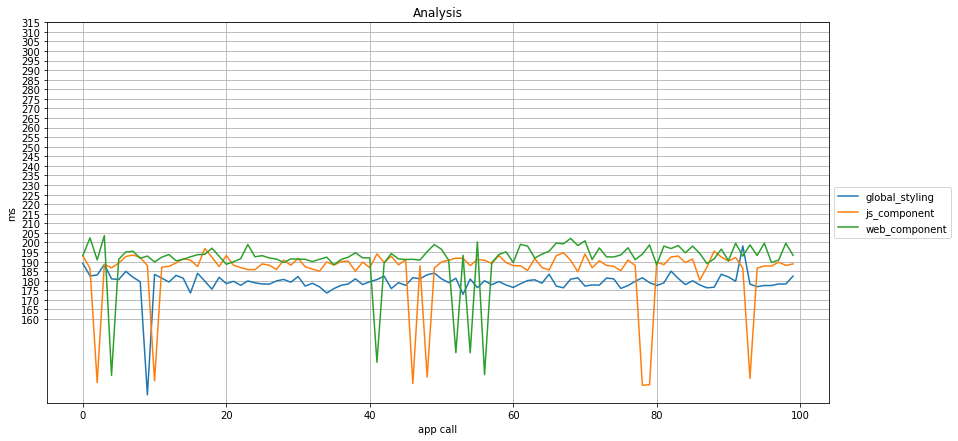

<Figure size 432x288 with 0 Axes>

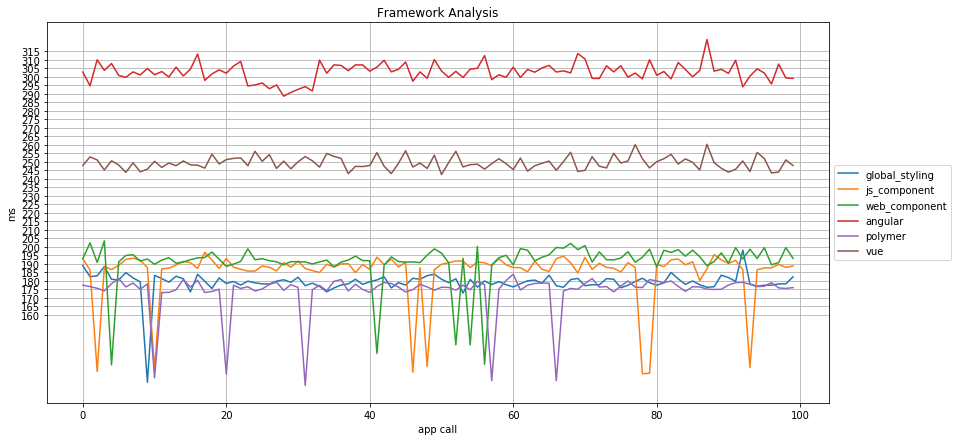

In [187]:
# figure for the plain components
f = plt.figure()
performance_dataframe_new_boot.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, 
                           yticks=range(160,320,5),stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

# figure for the web components created with the frameworks
f = plt.figure()
performance_dataframe_frameworks_new_boot.plot(kind='line',figsize=(14,7), title="Framework Analysis",
                                      yticks=range(160,320,5), grid=True,stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

From the graph it's obvious that there are huge spikes in the graph.

Probably that time, there was something going on on my network or background processes on my MacBook.

For getting better comparable results, let's flatten the graphs down, by replacing the outliers with mean values.

In [30]:

# first let's shorten down the long dataframe name
df = global_styling_dataframe_new_boot
mean = global_styling_dataframe_new_boot[0].mean()
std = global_styling_dataframe_new_boot[0].std()
# let's find the outliers that are outside the (mean - std) area 
# and replace them with the mean value
df[0] = np.where(df[0] < mean - std, mean,df[0])
# apply the flattened dataframe back to the original
global_styling_dataframe_new_boot = df

df = js_component_dataframe_new_boot
mean = js_component_dataframe_new_boot[0].mean()
std = js_component_dataframe_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
js_component_dataframe_new_boot = df

df = web_component_dataframe_new_boot
mean = web_component_dataframe_new_boot[0].mean()
std = web_component_dataframe_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
web_component_dataframe_new_boot = df

df = polymer_dataframe_new_boot
mean = polymer_dataframe_new_boot[0].mean()
std = polymer_dataframe_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
polymer_dataframe_new_boot = df

df = angular_dataframe_new_boot
mean = angular_dataframe_new_boot[0].mean()
std = angular_dataframe_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
angular_dataframe_new_boot = df

df = vue_dataframe_new_boot
mean = vue_dataframe_new_boot[0].mean()
std = vue_dataframe_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
vue_dataframe_new_boot = df



In [32]:
# create a dataframe for the plain components and set the column names
frames_new_boot = [global_styling_dataframe_new_boot, 
          js_component_dataframe_new_boot,
          web_component_dataframe_new_boot]
performance_columns = ['global_styling', 'js_component', 'web_component']
performance_dataframe_new_boot = pd.concat(frames_new_boot, axis=1, sort=False)
performance_dataframe_new_boot.columns = performance_columns

# create a dataframe out of the framework generated web components and define the column names
frames_frameworks_new_boot = [angular_dataframe_new_boot,
                     polymer_dataframe_new_boot,
                     vue_dataframe_new_boot]
performance_columns_frameworks = ['angular', 'polymer', 'vue']

# combine both dataframes
performance_dataframe_frameworks_new_boot = pd.concat(frames_new_boot + frames_frameworks_new_boot, axis=1, sort=False)
performance_dataframe_frameworks_new_boot.columns = performance_columns + performance_columns_frameworks

performance_dataframe_frameworks_new_boot.describe()

,global_styling,js_component,web_component,angular,polymer,vue
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,179.8,189.0,193.7,304.0,176.7,250.2
std,3.3,2.9,3.6,4.0,2.3,3.0
min,172.9,180.3,188.3,297.5,173.2,245.7
25%,177.8,186.9,191.1,301.7,174.9,248.2
50%,179.5,188.5,192.6,303.0,176.5,249.4
75%,181.3,191.0,196.4,305.8,178.4,251.9
max,198.2,196.8,203.6,322.0,183.9,260.4


The standard deviation goes down drastically from 16 to 3.6 for the web component.

Since we replaced outliers to the bottom, the mean values go up.

But we will get cleaner lines which will be better comparable.

<Figure size 432x288 with 0 Axes>

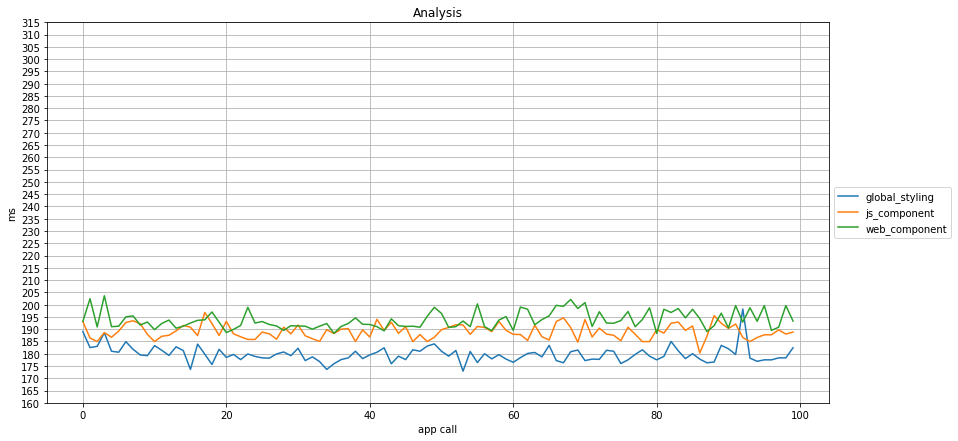

<Figure size 432x288 with 0 Axes>

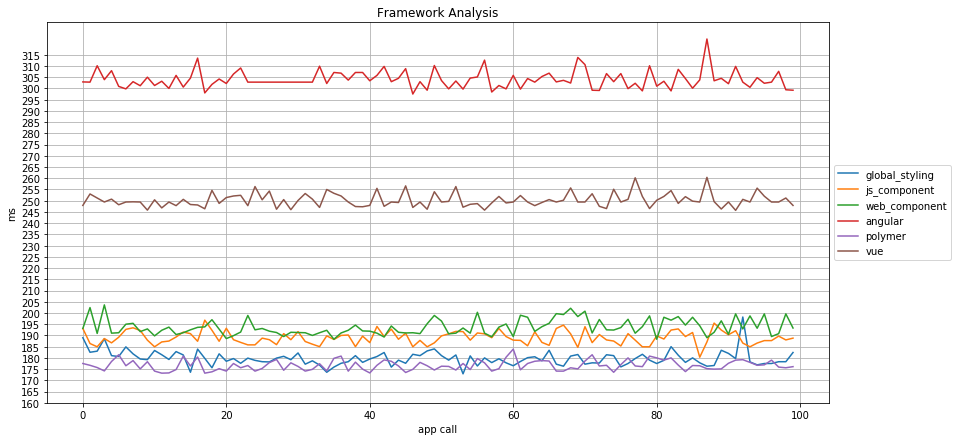

Text(0.5, 0.98, 'Performance Analyzes')

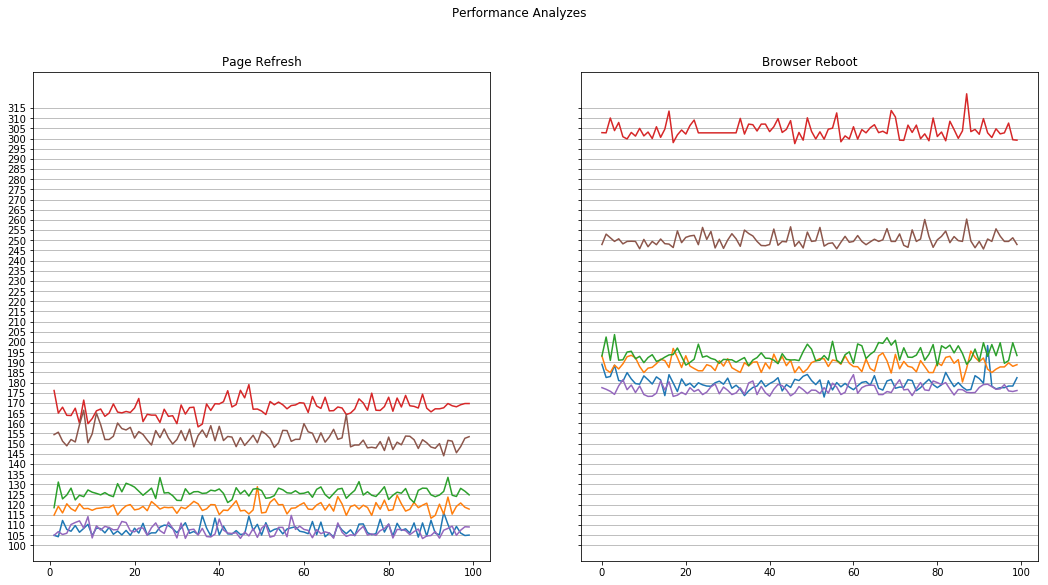

In [46]:
# figure for the plain components
f = plt.figure()
performance_dataframe_new_boot.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, 
                           yticks=range(160,320,5),stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

# figure for the web components created with the frameworks
f = plt.figure()
performance_dataframe_frameworks_new_boot.plot(kind='line',figsize=(14,7), title="Framework Analysis",
                                      yticks=range(160,320,5), grid=True,stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
axs[0].plot(performance_dataframe_frameworks)
axs[0].set_title('Page Refresh')
axs[0].yaxis.grid(True)
axs[0].set_yticks(range(100,320,5))
axs[1].plot(performance_dataframe_frameworks_new_boot)
axs[1].set_title('Browser Reboot')
axs[1].set_yticks(range(100,320,5))
axs[1].yaxis.grid(True)
fig.suptitle('Performance Analyzes')



The resulting graph looks very equal to the figure with the multiple page reload requests,  
if not looking at the miliseconds.  
But since we want to compare the performance between the components, this translation doesn't affect our analyzes.

This leaves us with the conclusion, that we are allowed to delete the first row from our `performance_dataframe` and `performance_dataframe_frameworks`.

In [18]:
# delete first row from dataframe
performance_dataframe = performance_dataframe.tail(-1)
performance_dataframe_frameworks = performance_dataframe_frameworks.tail(-1)

performance_dataframe_frameworks.describe()

,global_styling,js_component,web_component,angular,polymer,vue
count,99.0,99.0,99.0,99.0,99.0,99.0
mean,107.7,118.7,125.9,167.6,107.2,152.9
std,2.7,2.4,2.5,3.8,2.5,4.0
min,104.0,113.3,118.5,158.2,103.3,144.0
25%,105.5,117.3,124.6,165.4,105.0,150.4
50%,107.0,118.5,125.7,167.5,107.3,152.1
75%,109.6,120.0,127.4,169.6,108.6,155.2
max,116.1,128.8,133.4,179.0,114.7,166.4


The standard deviation is very low.  
- So we could already here conclude that polymer by far is the framework, which performs best.  
It is even at one level with the traditional global styling component *(distance d0)*
- the js component is about 10ms slower followed by the web component with the same distance (d1) of about 10ms
- vue is about 30ms slower then the web component, which is about 3 times the distance (d2)
- angular is about 10ms slower then vue, which corresponds to d1

Let's visualze our results as a line graph:

<Figure size 432x288 with 0 Axes>

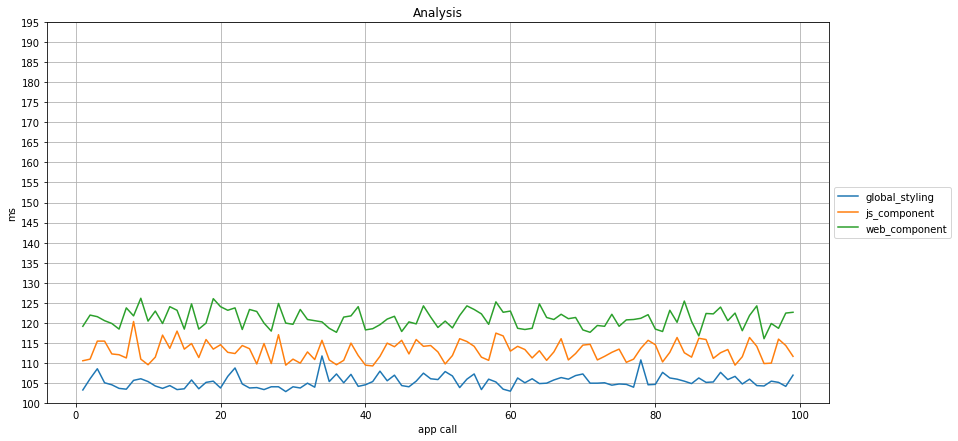

<Figure size 432x288 with 0 Axes>

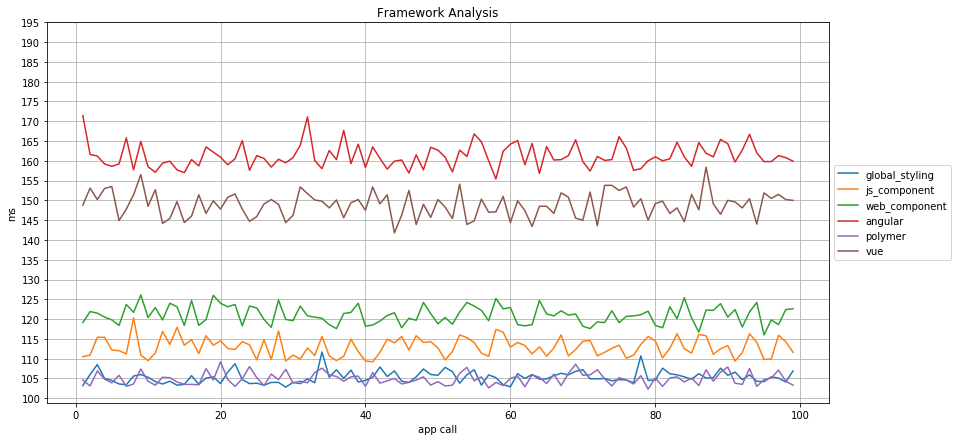

In [117]:
# figure for the plain components
f = plt.figure()
performance_dataframe.plot(kind='line',figsize=(14,7), title="Analysis", grid=True, 
                           yticks=range(100,200,5),stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

# figure for the web components created with the frameworks
f = plt.figure()
performance_dataframe_frameworks.plot(kind='line',figsize=(14,7), title="Framework Analysis",
                                      yticks=range(100,200,5), grid=True,stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

The results seem to be clear. But let's not jump to conclusions to fast.  
Most of the times a website will not consist of one web component only. So it is important to test, how the web components generated by the frameworks perform not measuring the framework addition.

We will do this by placing the framework specific scripts into the header region.  
So we can be sure, they will not add to the final web component measurement, which we do in the body.

- rewrite show html example
- start plain servers

For being able to distinguish between the plain framework generated web components and the full fledged component, I create a new folder `plain` inside each framework component.

```html

<head>
  <title>Web components Polymer - Stress Test (120)</title>
  <link rel="icon" href="static/favicon.ico" type="image/x-icon" />
  <style><!-- ... --></style>
  <script src="static/node_modules/@webcomponents/webcomponentsjs/webcomponents-loader.js"></script>
</head>
<body>
    <script>let bodyRendering = performance.now()</script>

    <h1>Polymer - Stress Test (120)</h1>
    <progress-bar id="progress-bar-1" class="pa-1"></progress-bar>
    <!-- ... -->
    <!-- ... -->
    <!-- ... -->
    <script type="module" src="static/progress-bar-polymer.js"></script>

    <script>
    // ...
    // inside our interval
        let progressInterval = setInterval(() => {
        
        // check whether you are in the first iteration round
            if(complete === 5) {
        
                // calculate the passed time of our body rendering 
                // and get the 'bodyRendering' token from LocalStorage
                let passedTime = parseFloat(performance.now()) - parseFloat(bodyRendering)
                let lsBR = JSON.parse(localStorage.getItem('bodyRendering'))
        
                // if the token in the LocalStorage exists, append the newly calculated time
                // otherwise create a new object with an array, 
                // that has the calculated time as it's initial item
                if(lsBR)
                    lsBR.push(passedTime)
                else
                    lsBR = [passedTime]

                localStorage.setItem('bodyRendering', JSON.stringify(lsBR))
            }
    // rest of our attribute modification
    // ...
    </script>
</body>

```


Let's start the servers for the plain framework generated web components:
First we need to start the servers of all the applications in a different terminal windows
- Plain Angular web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/03-angular && python3 ./server.py`
- Plain Polymer web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/04-polymer && python3 ./server.py`
- Plain Vue web component: `cd 03_Performance-Test/webcomponents/00_progress-bar/05-vue && python3 ./server.py`

*for better comparability I as well start the servers for the global_styling, js_component, and web_component.*


Now we need to measure the performance for the plain web components with the already defined `check_performance` function:

In [7]:
foldernames = ['03-angular', 
               '04-polymer', 
               '05-vue']

[check_performance(page_calls=100, foldername=foldernames[i] + '/plain', port=8003+i) for i in range(len(foldernames))]

🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/03-angular/plain/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/04-polymer/plain/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/05-vue/plain/BodyRendering.json"


[140.52100000017163, 105.630999999903, 144.7639999999774]

In [8]:
body_rendering_path = 'performance_test_result/00_progress-bar/'

# read the json files in with pandas
angular_dataframe_plain = pd.read_json(body_rendering_path + '03-angular/plain/BodyRendering.json')
polymer_dataframe_plain = pd.read_json(body_rendering_path + '04-polymer/plain/BodyRendering.json')
vue_dataframe_plain = pd.read_json(body_rendering_path + '05-vue/plain/BodyRendering.json')

In [11]:


# create a dataframe out of the framework generated web components and define the column names
frames_frameworks_plain = [angular_dataframe_plain,
                     polymer_dataframe_plain,
                     vue_dataframe_plain]

# combine both dataframes
performance_dataframe_frameworks_plain = pd.concat(frames + frames_frameworks_plain, axis=1, sort=False)
performance_dataframe_frameworks_plain.columns = performance_columns + performance_columns_frameworks
performance_dataframe_frameworks_plain = performance_dataframe_frameworks_plain.tail(-1)

performance_dataframe_frameworks_plain.describe()

,global_styling,js_component,web_component,angular,polymer,vue
count,99.0,99.0,99.0,99.0,99.0,99.0
mean,107.7,118.7,125.9,139.4,105.0,143.8
std,2.7,2.4,2.5,2.9,1.4,3.3
min,104.0,113.3,118.5,135.5,102.4,137.3
25%,105.5,117.3,124.6,137.8,104.2,141.1
50%,107.0,118.5,125.7,138.8,104.9,143.7
75%,109.6,120.0,127.4,140.6,105.7,145.6
max,116.1,128.8,133.4,154.5,108.8,152.1


The standard deviation is pretty low, which allows us to compare the mean values more reliably.  

- We see that the angular web component and vue web component get closer to the plain web component.
- The polymer component by far competes best here.

Let's take a look at the line graph:

<Figure size 432x288 with 0 Axes>

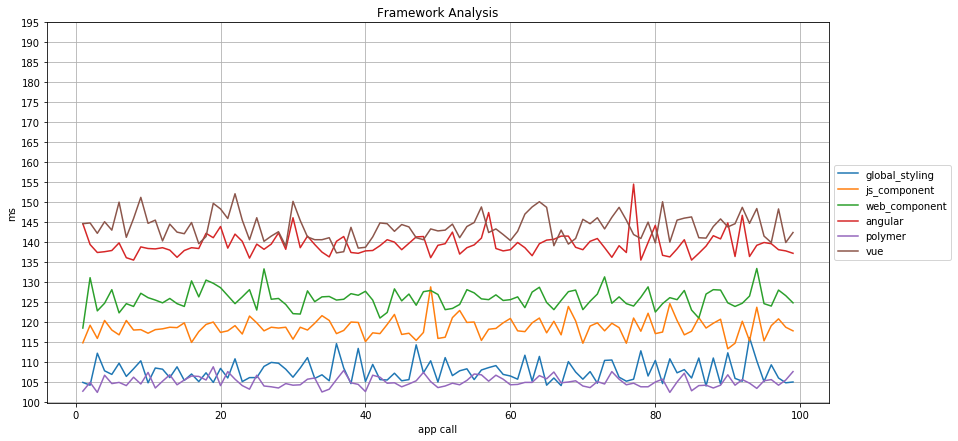

Text(0.5, 0.98, 'Categorical Plotting')

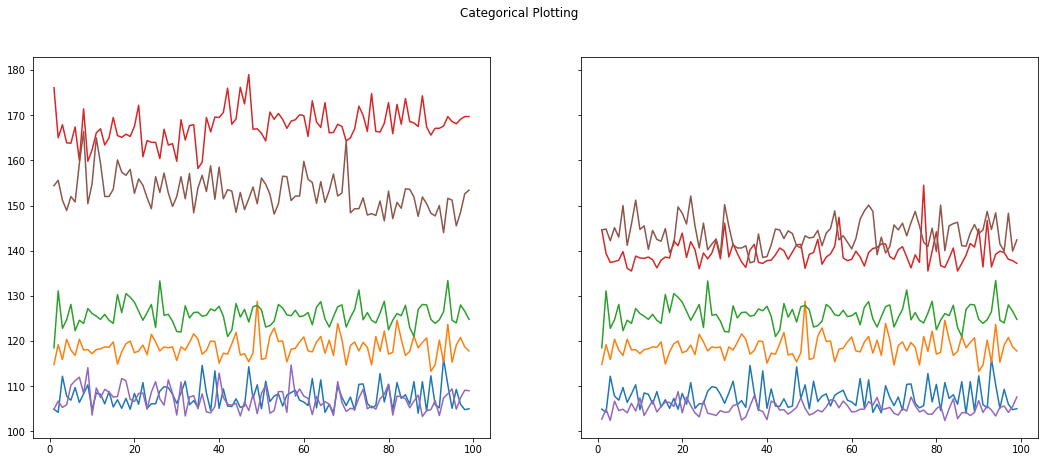

In [57]:

f = plt.figure()
performance_dataframe_frameworks_plain.plot(kind='line',figsize=(14,7), title="Framework Analysis",
                                      yticks=range(100,200,5), grid=True,stacked = False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("ms")
plt.xlabel("app call")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
axs[0].plot(performance_dataframe_frameworks)
axs[1].plot(performance_dataframe_frameworks_plain)
fig.suptitle('Categorical Plotting')

In [48]:
foldernames = ['03-angular', 
               '04-polymer', 
               '05-vue']

[check_performance_new_boot(page_calls=100, foldername=foldernames[i] + '/new_boot/plain', port=8003+i) for i in range(len(foldernames))]

🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/03-angular/new_boot/plain/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/04-polymer/new_boot/plain/BodyRendering.json"
🥳  🎉 🍾 Yay, successfully created "performance_test_result/00_progress-bar/05-vue/new_boot/plain/BodyRendering.json"


[247.8810000001249, 166.18600000001607, 214.91900000000896]

In [50]:
body_rendering_path = 'performance_test_result/00_progress-bar/'

# read the json files in with pandas
angular_dataframe_plain_new_boot = pd.read_json(body_rendering_path + '03-angular/new_boot/plain/BodyRendering.json')
polymer_dataframe_plain_new_boot = pd.read_json(body_rendering_path + '04-polymer/new_boot/plain/BodyRendering.json')
vue_dataframe_plain_new_boot = pd.read_json(body_rendering_path + '05-vue/new_boot/plain/BodyRendering.json')

In [55]:
# create a dataframe out of the framework generated web components and define the column names
frames_frameworks_plain_new_boot = [angular_dataframe_plain_new_boot,
                     polymer_dataframe_plain_new_boot,
                     vue_dataframe_plain_new_boot]

# combine both dataframes
performance_dataframe_frameworks_plain_new_boot = pd.concat(frames_new_boot + frames_frameworks_plain_new_boot, axis=1, sort=False)
performance_dataframe_frameworks_plain_new_boot.columns = performance_columns + performance_columns_frameworks

performance_dataframe_frameworks_plain_new_boot.describe()

,global_styling,js_component,web_component,angular,polymer,vue
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,179.8,189.0,193.7,247.9,166.2,214.9
std,3.3,2.9,3.6,3.8,9.5,22.7
min,172.9,180.3,188.3,238.4,107.3,156.7
25%,177.8,186.9,191.1,245.4,166.7,219.3
50%,179.5,188.5,192.6,247.7,168.1,222.5
75%,181.3,191.0,196.4,249.9,169.4,224.4
max,198.2,196.8,203.6,259.5,174.8,261.9


Text(0.5, 0.98, 'Categorical Plotting')

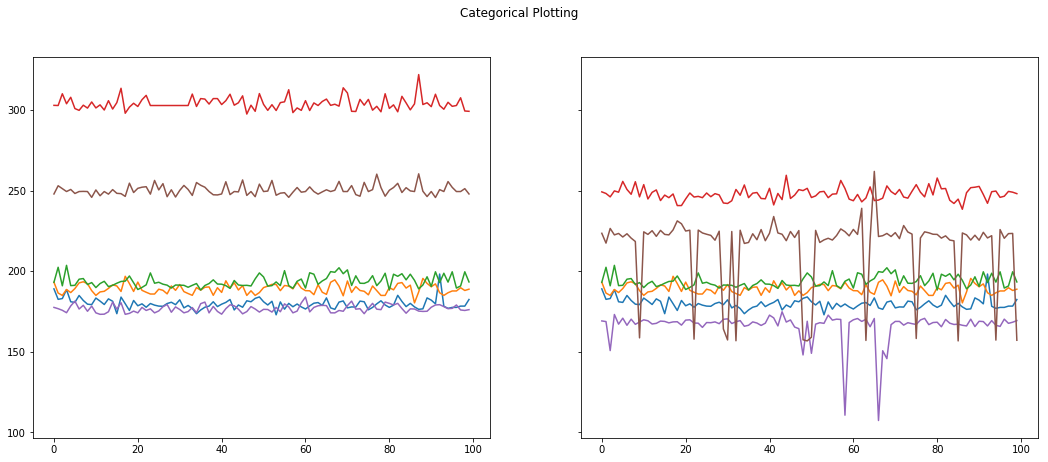

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
axs[0].plot(performance_dataframe_frameworks_new_boot)
axs[1].plot(performance_dataframe_frameworks_plain_new_boot)
fig.suptitle('Categorical Plotting')

In [59]:
df = polymer_dataframe_plain_new_boot
mean = polymer_dataframe_plain_new_boot[0].mean()
std = polymer_dataframe_plain_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
polymer_dataframe_plain_new_boot = df

df = angular_dataframe_plain_new_boot
mean = angular_dataframe_plain_new_boot[0].mean()
std = angular_dataframe_plain_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
angular_dataframe_plain_new_boot = df

df = vue_dataframe_plain_new_boot
mean = vue_dataframe_plain_new_boot[0].mean()
std = vue_dataframe_plain_new_boot[0].std()
df[0] = np.where(df[0] < mean - std, mean,df[0])
vue_dataframe_plain_new_boot = df



In [61]:
# create a dataframe out of the framework generated web components and define the column names
frames_frameworks_plain_new_boot = [angular_dataframe_plain_new_boot,
                     polymer_dataframe_plain_new_boot,
                     vue_dataframe_plain_new_boot]

# combine both dataframes
performance_dataframe_frameworks_plain_new_boot = pd.concat(frames_new_boot + frames_frameworks_plain_new_boot, axis=1, sort=False)
performance_dataframe_frameworks_plain_new_boot.columns = performance_columns + performance_columns_frameworks

performance_dataframe_frameworks_plain_new_boot.describe()

,global_styling,js_component,web_component,angular,polymer,vue
count,100.0,100.0,100.0,100.0,100.0,100.0
mean,179.8,189.0,193.7,248.7,168.2,222.3
std,3.3,2.9,3.6,3.0,1.9,5.8
min,172.9,180.3,188.3,244.1,164.3,214.9
25%,177.8,186.9,191.1,246.5,166.7,219.3
50%,179.5,188.5,192.6,247.9,168.1,222.5
75%,181.3,191.0,196.4,249.9,169.4,224.4
max,198.2,196.8,203.6,259.5,174.8,261.9


Text(0.5, 0.98, 'Performance Analysis')

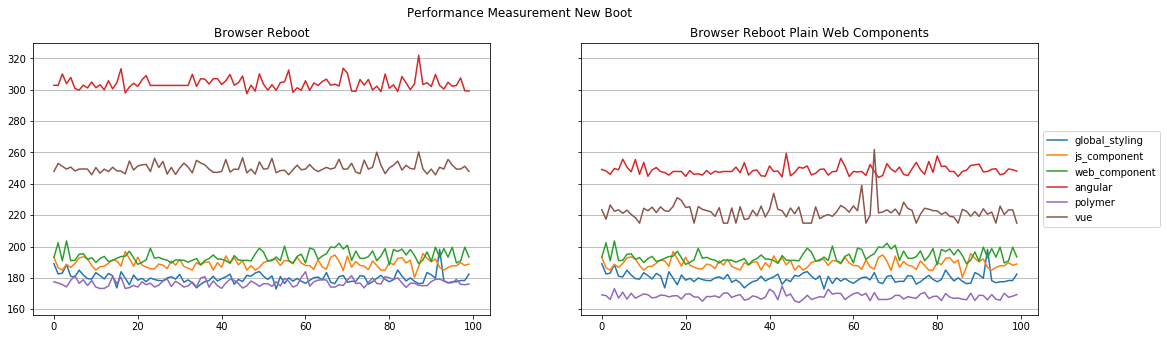

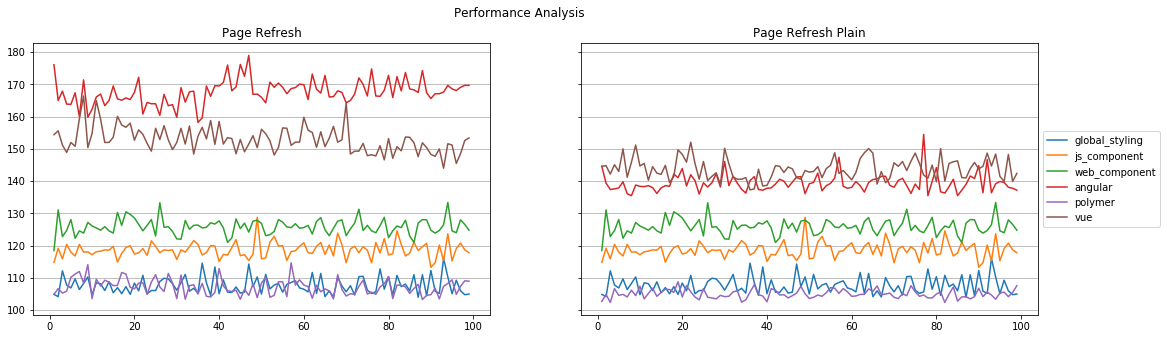

In [89]:

fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
title = ['Browser Reboot', 'Browser Reboot Plain Web Components']
pDF = [performance_dataframe_frameworks_new_boot, performance_dataframe_frameworks_plain_new_boot]
for i in range(2):
	axs[i].plot(pDF[i])
	axs[i].set_title(title[i])
	axs[i].yaxis.grid(True)
#	axs[i].set_yticks(range(100,300,50))
    
axs[1].legend(performance_columns + performance_columns_frameworks, loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Performance Measurement New Boot')


fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=True)
plt.yticks=(range(100,300,50))
title = ['Page Refresh', 'Page Refresh Plain']
pDF = [performance_dataframe_frameworks, performance_dataframe_frameworks_plain]
for i in range(2):
	axs[i].plot(pDF[i])
	axs[i].set_title(title[i])
#	axs[i].set_yticks(range(100,180,5), minor=False)
	axs[i].yaxis.grid(True)
    
axs[1].legend(performance_columns + performance_columns_frameworks, loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Performance Analysis')


-----
-----
-----
----